<a href="https://colab.research.google.com/github/harishkumarsg/medical_encryption/blob/main/medical_encryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.1955 - learning_rate: 0.0010
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - loss: 0.1474 - learning_rate: 0.0010
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - loss: 0.1018 - learning_rate: 0.0010
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 0.0821 - learning_rate: 0.0010
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - loss: 0.0733 - learning_rate: 0.0010
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 0.0687 - learning_rate: 0.0010
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.0653 - learning_rate: 0.0010
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.0622 - learning_rate: 0.0010
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0596 - learning_rate: 0.0010
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0575 - learning_rate: 0.0010
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.055

<ipython-input-1-ff24041700b3>:90: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_val = psnr(original_img / 255.0, decoded_img)


Single Image CNN + LSB
  PSNR: 30.46 dB
  SSIM: 0.9822
  Time: 0.01 sec


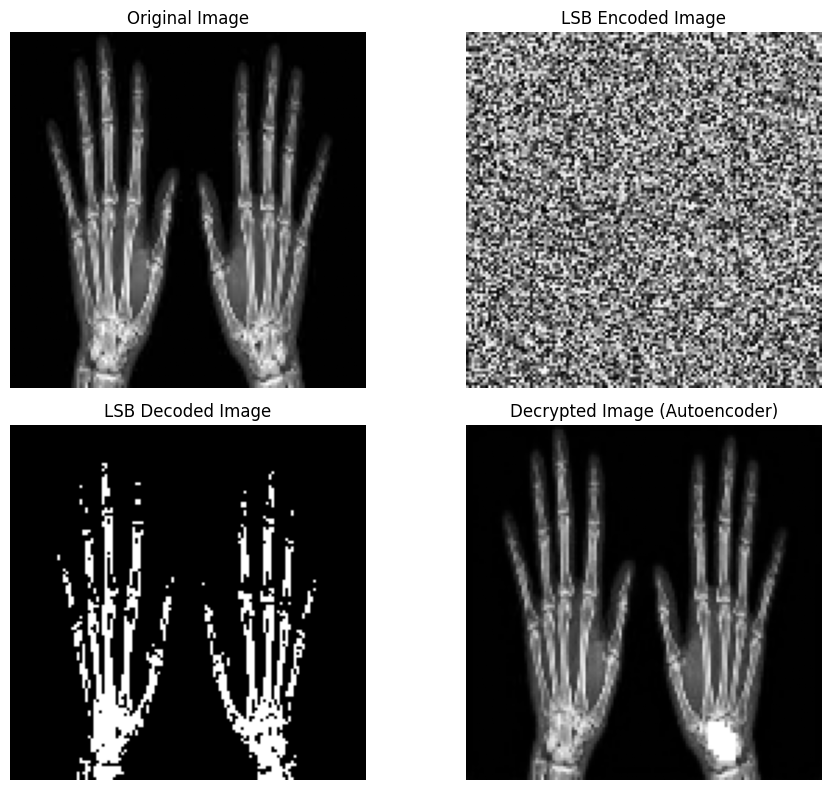

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import time
import os

# Define output path
output_path = '/content/drive/MyDrive/image_outputs'
os.makedirs(output_path, exist_ok=True)

# Load and prepare the image
img_path = '/content/xray.jpg'
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
original_img = cv2.resize(original_img, (128, 128))
input_img = original_img / 255.0
input_img = np.reshape(input_img, (1, 128, 128, 1))

# Define deeper autoencoder
inp = Input(shape=(128, 128, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

# Learning rate schedule
def lr_scheduler(epoch):
    if epoch < 1000:
        return 0.001
    elif epoch < 2000:
        return 0.0005
    else:
        return 0.0001

lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model
autoencoder.fit(input_img, input_img, epochs=2000, verbose=1, callbacks=[lr_schedule])

# Decode the image
decoded_img = autoencoder.predict(input_img)[0].squeeze()
decoded_img_uint8 = (decoded_img * 255).astype(np.uint8)

# LSB steganography functions
def lsb_encode(cover, secret):
    secret = cv2.resize(secret, (cover.shape[1], cover.shape[0]))
    return (cover & 0xFE) | (secret >> 7)

def lsb_decode(encoded):
    return (encoded & 0x01) * 255

# Generate cover image and apply LSB
cover_img = np.random.randint(0, 256, (128, 128), dtype=np.uint8)
lsb_encoded = lsb_encode(cover_img, original_img)
lsb_decoded = lsb_decode(lsb_encoded)

# Save all images
cv2.imwrite(os.path.join(output_path, 'original_image.png'), original_img)
cv2.imwrite(os.path.join(output_path, 'lsb_encoded_image.png'), lsb_encoded)
cv2.imwrite(os.path.join(output_path, 'lsb_decoded_image.png'), lsb_decoded)
cv2.imwrite(os.path.join(output_path, 'decrypted_image.png'), decoded_img_uint8)

# Evaluate image quality
start = time.time()
psnr_val = psnr(original_img / 255.0, decoded_img)
ssim_val = ssim(original_img / 255.0, decoded_img, data_range=1)
duration = time.time() - start

print("Single Image CNN + LSB")
print(f"  PSNR: {psnr_val:.2f} dB")
print(f"  SSIM: {ssim_val:.4f}")
print(f"  Time: {duration:.2f} sec")

# Display all images
titles = ['Original Image', 'LSB Encoded Image', 'LSB Decoded Image', 'Decrypted Image (Autoencoder)']
images = [original_img, lsb_encoded, lsb_decoded, decoded_img_uint8]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.1718 - learning_rate: 1.0000e-04
Epoch 2/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.1715 - learning_rate: 1.0000e-04
Epoch 3/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 4/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 5/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1704 - learning_rate: 1.0000e-04
Epoch 6/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1701 - learning_rate: 1.0000e-04
Epoch 7/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.1697 - learning_rate: 1.0000e-04
Epoch 8/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.1693 - learning_rate: 1.0000e-04
Epoch 9/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.1689 - learning_rate: 1.0000e-04
Epoch 10/1500
1/1

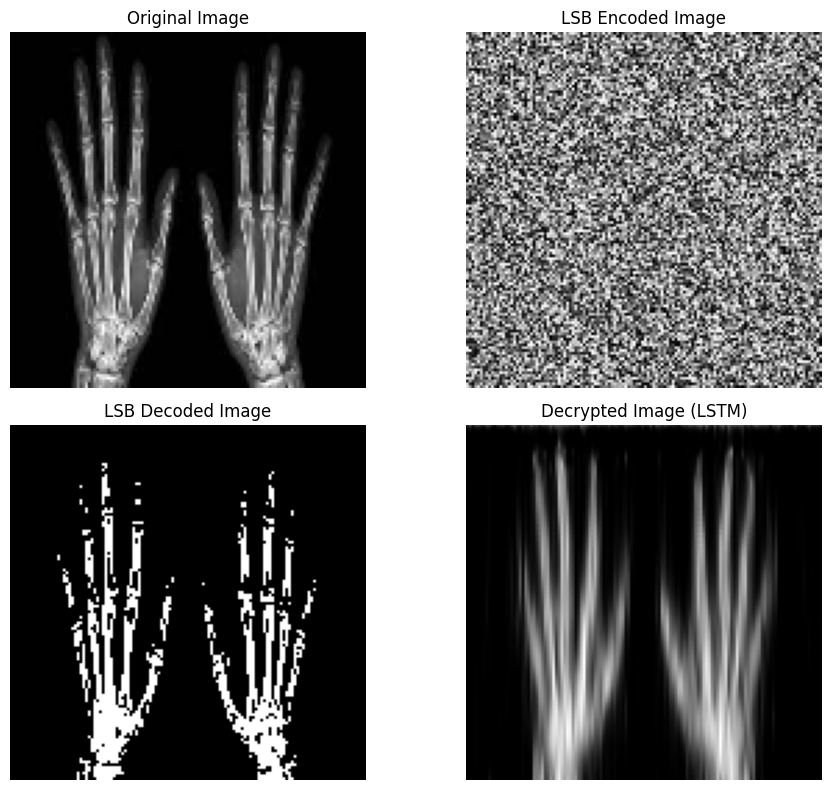

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, Callback
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import time
import os

# Output folder path
output_path = '/content/drive/MyDrive/lstm_outputs'
os.makedirs(output_path, exist_ok=True)

# Load and preprocess the image
img_path = '/content/xray.jpg'
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original_img is None:
    raise ValueError(f"Image not found at: {img_path}")

original_img = cv2.resize(original_img, (128, 128))
input_img = original_img.astype(np.float32) / 255.0

# Reshape for LSTM input (samples, time_steps, features)
input_lstm = np.reshape(input_img, (1, 128, 128))

# Define LSTM Autoencoder
inp = Input(shape=(128, 128))
x = LSTM(128, activation='relu', return_sequences=False)(inp)
x = RepeatVector(128)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)
x = TimeDistributed(Dense(128, activation='sigmoid'))(x)
autoencoder = Model(inp, x)
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Learning Rate Scheduler
def lr_scheduler(epoch):
    if epoch < 500:
        return 0.0001
    elif epoch < 1000:
        return 0.00005
    else:
        return 0.00001

lr_schedule = LearningRateScheduler(lr_scheduler)

# Callback to stop training on NaN or Inf
class CheckNaNCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if np.isnan(logs.get('loss')) or np.isinf(logs.get('loss')):
            print(f"NaN or Inf detected in loss at epoch {epoch}. Stopping training.")
            self.model.stop_training = True

check_nan_callback = CheckNaNCallback()

# Train the model
autoencoder.fit(input_lstm, input_lstm, epochs=1500, verbose=1, callbacks=[check_nan_callback, lr_schedule])

# Predict (decode)
decoded_lstm = autoencoder.predict(input_lstm)[0]
decoded_img = np.clip(decoded_lstm * 255, 0, 255).astype(np.uint8)

# LSB encode/decode functions
def lsb_encode(cover_img, secret_img):
    secret_img = cv2.resize(secret_img, (cover_img.shape[1], cover_img.shape[0]))
    return (cover_img & 0xFE) | (secret_img >> 7)

def lsb_decode(encoded_img):
    return ((encoded_img & 0x01) * 255).astype(np.uint8)

# LSB embedding and decoding
cover_img = np.random.randint(0, 256, (128, 128), dtype=np.uint8)
lsb_encoded = lsb_encode(cover_img, original_img)
lsb_decoded = lsb_decode(lsb_encoded)

# Save images
cv2.imwrite(os.path.join(output_path, 'original_lstm_image.png'), original_img)
cv2.imwrite(os.path.join(output_path, 'lsb_encoded_lstm.png'), lsb_encoded)
cv2.imwrite(os.path.join(output_path, 'lsb_decoded_lstm.png'), lsb_decoded)
cv2.imwrite(os.path.join(output_path, 'decrypted_lstm_image.png'), decoded_img)

# Evaluation
start = time.time()
psnr_val = psnr(input_img, decoded_lstm)
ssim_val = ssim(input_img, decoded_lstm, data_range=1)
duration = time.time() - start

print(f"LSTM Autoencoder + LSB")
print(f"  PSNR: {psnr_val:.2f} dB")
print(f"  SSIM: {ssim_val:.4f}")
print(f"  Time: {duration:.2f} sec")

# Display images in a 2x2 grid
titles = ['Original Image', 'LSB Encoded Image', 'LSB Decoded Image', 'Decrypted Image (LSTM)']
images = [original_img, lsb_encoded, lsb_decoded, decoded_img]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7049, acc.: 0.00%] [G loss: 0.6804]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1

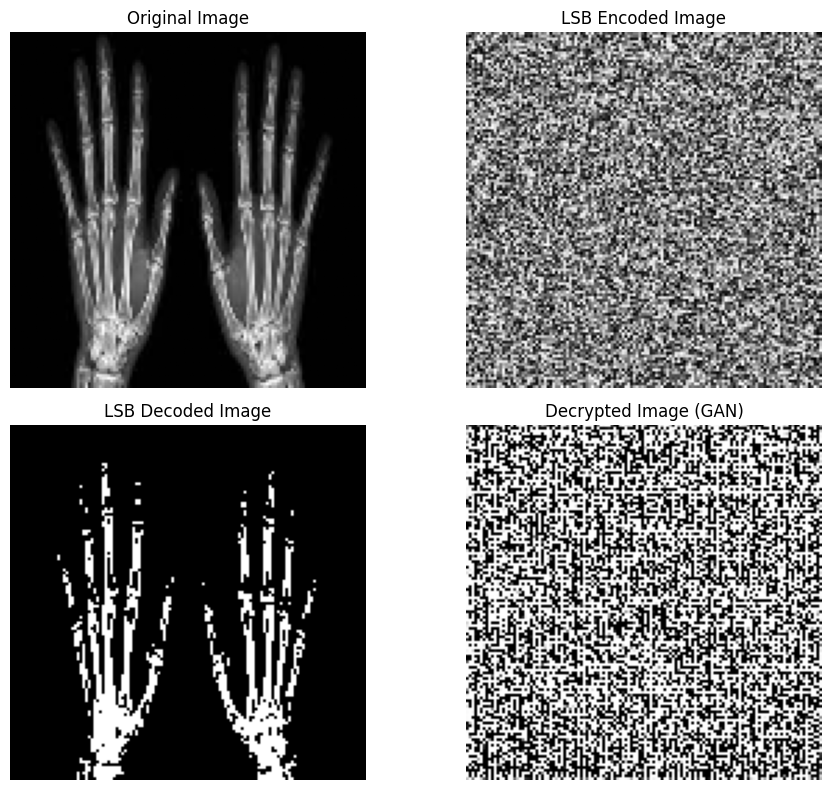

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time, os
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Input
from keras.optimizers import Adam
from keras.callbacks import Callback
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Output directory
output_path = '/content/drive/MyDrive/gan_outputs'
os.makedirs(output_path, exist_ok=True)

# Load image
img_path = '/content/xray.jpg'
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if original_img is None:
    raise ValueError(f"Image not found at: {img_path}")
original_img = cv2.resize(original_img, (128, 128))
input_img = original_img.astype(np.float32) / 255.0
input_img = np.expand_dims(input_img, axis=(0, -1))

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 16 * 16, activation="relu", input_dim=100))
    model.add(Reshape((16, 16, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(128, 128, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Initialize GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])

z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')

# GAN Training
epochs = 3000
batch_size = 1
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    real_imgs = input_img
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch(noise, valid)

    if epoch % 500 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

# Generate image
generated_img = generator.predict(np.random.normal(0, 1, (1, 100)))[0]
decoded_img = np.clip(generated_img * 255, 0, 255).astype(np.uint8).squeeze()

# LSB encode/decode
def lsb_encode(cover_img, secret_img):
    secret_img = cv2.resize(secret_img, (cover_img.shape[1], cover_img.shape[0]))
    return (cover_img & 0xFE) | (secret_img >> 7)

def lsb_decode(encoded_img):
    return ((encoded_img & 0x01) * 255).astype(np.uint8)

# Apply LSB
cover_img = np.random.randint(0, 256, (128, 128), dtype=np.uint8)
lsb_encoded = lsb_encode(cover_img, original_img)
lsb_decoded = lsb_decode(lsb_encoded)

# Save images
cv2.imwrite(os.path.join(output_path, 'original_gan_image.png'), original_img)
cv2.imwrite(os.path.join(output_path, 'lsb_encoded_gan.png'), lsb_encoded)
cv2.imwrite(os.path.join(output_path, 'lsb_decoded_gan.png'), lsb_decoded)
cv2.imwrite(os.path.join(output_path, 'decrypted_gan_image.png'), decoded_img)

# Evaluation
start = time.time()
psnr_val = psnr(input_img.squeeze(), generated_img.squeeze(), data_range=1)
ssim_val = ssim(input_img.squeeze(), generated_img.squeeze(), data_range=1)
duration = time.time() - start

print(f"GAN + LSB")
print(f"  PSNR: {psnr_val:.2f} dB")
print(f"  SSIM: {ssim_val:.4f}")
print(f"  Time: {duration:.2f} sec")

# Display all images
titles = ['Original Image', 'LSB Encoded Image', 'LSB Decoded Image', 'Decrypted Image (GAN)']
images = [original_img, lsb_encoded, lsb_decoded, decoded_img]

plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


=== Model Comparison ===
CNN + Autoencoder: PSNR = 32.77 dB, SSIM = 0.9841
LSTM Autoencoder: PSNR = 19.74 dB, SSIM = 0.6360
GAN + CNN: PSNR = 3.66 dB, SSIM = 0.0026


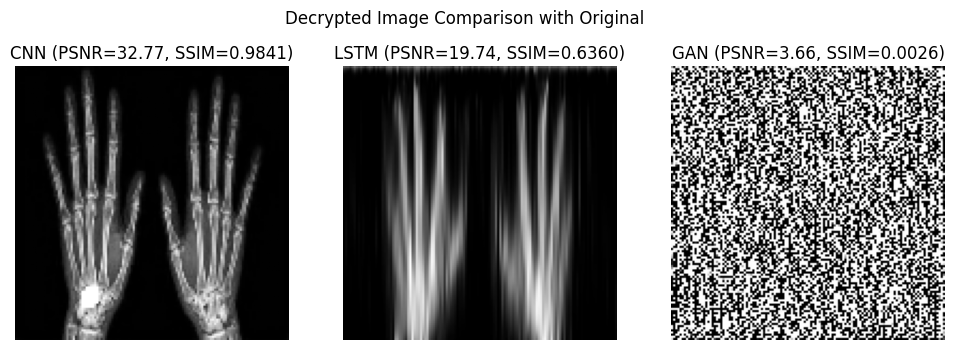

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
original_path = '/content/xray.jpg'
cnn_path = '/content/drive/MyDrive/decrypted_single_image.png'
lstm_path = '/content/drive/MyDrive/decrypted_lstm_image.png'
gan_path = '/content/drive/MyDrive/decrypted_gan_image.png'

# Load images
def load_image_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    img = cv2.resize(img, (128, 128)).astype(np.float32) / 255.0
    return img

original_img = load_image_gray(original_path)
cnn_img = load_image_gray(cnn_path)
lstm_img = load_image_gray(lstm_path)
gan_img = load_image_gray(gan_path)

# Compare
def compare(img1, img2, label):
    p = psnr(img1, img2, data_range=1)
    s = ssim(img1, img2, data_range=1)
    print(f"{label}: PSNR = {p:.2f} dB, SSIM = {s:.4f}")
    return p, s

print("=== Model Comparison ===")
psnr_cnn, ssim_cnn = compare(original_img, cnn_img, "CNN + Autoencoder")
psnr_lstm, ssim_lstm = compare(original_img, lstm_img, "LSTM Autoencoder")
psnr_gan, ssim_gan = compare(original_img, gan_img, "GAN + CNN")

# Plot images
titles = [
    f"CNN (PSNR={psnr_cnn:.2f}, SSIM={ssim_cnn:.4f})",
    f"LSTM (PSNR={psnr_lstm:.2f}, SSIM={ssim_lstm:.4f})",
    f"GAN (PSNR={psnr_gan:.2f}, SSIM={ssim_gan:.4f})"
]
images = [cnn_img, lstm_img, gan_img]

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.suptitle("Decrypted Image Comparison with Original")
plt.show()